# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)
- 24/11/2023:
    - Included loading of document loader cache options (DLCOs)
- 26/11/2023
    - Histogram plots per DLCO group, for `deriveIdentityCredential`, `deriveDiplomaCredential`, `verifyPresentation01`, and `verifyPresentation02`

---

Todos:

- integrate host reports (since profiler-v2)


In [1]:
import os
import json
import git
import re
import numpy as np
np.random.seed(42)
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2024-01-17T13:05:48'

Plot config

In [2]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [3]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


def read_json(fpath: str) -> dict:
    return json.loads(open(fpath, 'r').read())

def parse_js_timestamp(jsts: int):
    """Parse timestamps created using JS/TS's `Date.now()`.
    Ref: https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now
    """
    return datetime.datetime.utcfromtimestamp(jsts/1000)


## Input data

WIP: incorporating multi-actor profiling reports with varying document loader option configurations.

Note: timestamps were created using JS/TS's `Date.now()`.

> The Date.now() static method returns the number of milliseconds elapsed since the epoch, which is defined as the midnight at the beginning of January 1, 1970, UTC.

<https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now>

In [4]:
def create_df_files(s_json_report_files: pd.Series) -> pd.DataFrame:
    # Split filepaths into a parentdir & the basename of the json file
    df_files = s_json_report_files.apply(os.path.split).apply(pd.Series)
    df_files.columns = ['parent_dir','basename']
    df_files['fpath'] = s_json_report_files
    # Parse the timestamps (cfr. Date.now() in JS/TS)
    df_files['parent_dir_ts'] = df_files.parent_dir.apply(os.path.basename).astype(int).apply(parse_js_timestamp)
    df_files['report_ts'] = df_files.basename.str.replace('.json','').apply(lambda x: x.split('-')[-1]).astype(int).apply(parse_js_timestamp)
    return df_files

def load_df_reports(s_json_report_files: pd.Series) -> pd.DataFrame:
    """ 
    :param: s_json_report_files is a pd.Series containing paths to every experiment records
    :return: dataframe with loaded JSON experiment records
    """
    df_files = create_df_files(s_json_report_files)    
    _df = df_files.iloc[:].fpath.apply(read_json).apply(pd.Series)
    _df = _df.merge(df_files[['report_ts']], left_index=True, right_index=True)
    return _df
    
def extract_dlco_df(df: pd.DataFrame) -> pd.DataFrame:
    """ Expects df to be the dataframe created from the JSON reports
    """
    # Process Document Loader Cache Options
    _df_dlco = df['documentLoaderCacheOptions'].apply(pd.Series).stack().apply(pd.Series).unstack(1).swaplevel(axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    _df_dlco.index.set_names('idx_report',inplace=True)
    # Flatten columns
    _df_dlco.columns = list(map(lambda t: '_'.join(t), _df_dlco.columns))
    
    return _df_dlco

def extract_record_df(df: pd.DataFrame) -> pd.DataFrame:
    """ Extracts and expands the records column.
    """
    _df_records = df.records.apply(pd.Series).stack()
    _df_records.index.set_names(['idx_report','idx_step'],inplace=True)
    _df_records = _df_records.apply(pd.Series).drop('index',axis=1)
    return _df_records.reset_index().merge(df[['report_ts']], left_on=['idx_report'], right_index=True).set_index(['idx_report','idx_step'])
    #return _df_records

def create_report_df(s_json_report_files: pd.Series) -> pd.DataFrame:
    """v20231125 - expects pd.Series containing the paths to the multi-actor report (JSON).
    These reports are expected to also include other metadata (e.g. document loader cache option configuration)
    Returns pd.DataFrame from parsed records
    """
    # Read JSON files into a dataframe
    _df = load_df_reports(s_json_report_files)

    # Extract DLCO dataframe
    _df_dlco = extract_dlco_df(_df)

    # Process multi actor records
    _df_records = extract_record_df(_df)
    
    # Combine
    _df_result = pd.concat({'report': _df_records,}, axis=1).merge(pd.concat({'dlco':_df_dlco}, axis=1), left_index=True, right_index=True)
    assert _df_result.shape[0] == _df_records.shape[0] # sanity check
    
    # Column renaming
    _df_result.rename({'tag': 'actorTag', 'name': 'stepName', },axis=1,inplace=True)
    _df_result[('report','actorStep')] = _df_result.apply(lambda r: f'{r.report.actorTag}.{r.report.stepName}',axis=1)
    _df_result.sort_index(axis=1,inplace=True)
    return _df_result
    

## Analysis

In [5]:
AGG_FUNCTIONS = ['median','mean', 'std', 'min','max','count',pd.Series.skew, pd.Series.kurt]

---

In [6]:
def create_solution_label_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Sanity check: in every report, there must be exactly one className per actorTag (otherwise, smth went wrong)
    assert (df.report.reset_index().groupby(['idx_report','actorTag'])['className'].unique().apply(len) == 1).all()    
    # Create a dataframe that labels which solution the report represents (the solution label depends on which kind of implementation was used for actor Alice)
    df_report_solution_label = df.report.reset_index().groupby(['idx_report','actorTag'])['className'].unique().apply(lambda x: x[0]).unstack('actorTag')
    def extract_solution_label(r):
        assert r.alice.startswith('CompoundCredentialActor') # sanity check
        # The first and second classnames are used for the public and pseudonymous identity, respectively.
        [public_identity_classname, pseudo_identity_classname] = r.alice.replace('CompoundCredentialActor<','').replace('>','').split(',')

        lbl = None
        if pseudo_identity_classname == 'SolidVCActor':
            lbl = 'third-party'
        elif pseudo_identity_classname == 'DidVCActor':
            lbl = 'did-key'
        else:
            raise Exception(f'Cannot create solution label for {pseudo_identity_classname}')
        return lbl
    df_report_solution_label['solution_label'] = df_report_solution_label.apply(extract_solution_label, axis=1)
    return df_report_solution_label
    
def get_report_paths() -> pd.Series:
    return pd.Series(glob('./reports/profiling/*/*.json'))

def get_df() -> pd.DataFrame:

    df = create_report_df(get_report_paths())
    n0 = df.shape[0]
    df_report_solution_label = create_solution_label_dataframe(df)
    df = df.reset_index().set_index(['idx_report']).merge(pd.concat({'report':df_report_solution_label[['solution_label']]},axis=1),left_index=True, right_index=True)
    n1 = df.shape[0]
    assert n0 == n1
    return df
df = get_df()
df.shape

(6000, 14)

In [7]:
# Count the nr. of experiments per different DLCO configuration
df.dlco.apply(list,axis=1).value_counts()

[True, True, True]    6000
Name: count, dtype: int64

In [8]:
df.reset_index().groupby('idx_report').count().stack()

/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_71429/2154925118.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.reset_index().groupby('idx_report').count().stack()


idx_step  dlco  \
idx_report                                                                      
0                                                                  12.0   NaN   
           DID_cacheResolvedDIDDocs                                 NaN  12.0   
           HTTP_cacheWebResourcesResolvedFromLocalHostInst...       NaN  12.0   
           HTTP_cacheWebResourcesResolvedFromTheWeb                 NaN  12.0   
           actorStep                                                NaN   NaN   
...                                                                 ...   ...   
499        output                                                   NaN   NaN   
           report_ts                                                NaN   NaN   
           solution_label                                           NaN   NaN   
           start                                                    NaN   NaN   
           stepName                                                 NaN   NaN   

                                                               report  
idx_report                                                             
0                                                                 NaN  
           DID_cacheResolvedDIDDocs                               NaN  
           HTTP_cacheWebResourcesResolvedFromLocalHostInst...     NaN  
           HTTP_cacheWebResourcesResolvedFromTheWeb               NaN  
           actorStep                                             12.0  
...                                                               ...  
499        output                                                12.0  
           report_ts                                             12.0  
           solution_label                                        12.0  
           start                                                 12.0  
           stepName                                              12.0  

[7000 rows x 3 columns]

In [9]:
df.report.solution_label.reset_index().groupby('idx_report').first().solution_label.value_counts()

solution_label
third-party    250
did-key        250
Name: count, dtype: int64

The reports will be considered in groups, divided by the following group columns:
    
- `actorTag`: the name/tag of an actor within the context of the use case (e.g. alice)
- `className`: the classname of an actor's implementation (e.g. `SolidVCACtor`)
- `actorStep` the profiled step/action taken by the actor (e.g. `verifyPresentation`)

In [10]:
def equalize_groupsizes(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    """ Creates equally sized groups (based on the smallest group size).
    """
    grpr = df.groupby(group_columns)
    n_smallest_group = grpr.size().min()
    idx_to_drop = []
    for i,g_idx in grpr.groups.items():
        ni_idx_to_drop = g_idx.size - n_smallest_group
        np.random.seed(42)
        idx_to_drop.append(np.random.choice(g_idx,size=ni_idx_to_drop))

    idx_to_drop = np.concatenate(idx_to_drop)
    return df.drop(index=idx_to_drop)

In [11]:
def jsonpath2multi_index_tuple(path: str):
    """
    Example: 
    jsonpath2multi_index_tuple('report.actorTag')
    ('report', 'actorTag')
    """
    return tuple(path.split('.'))

In [12]:
jsonpath2multi_index_tuple('report.actorTag')

('report', 'actorTag')

In [13]:
# Add phases
phase_steps = {
    'pre-evaluation': [
        'university.createDiplomaCredential',
        'university.signDiplomaCredential',
        'government.createIdentityCredential',
        'government.signIdentityCredential',
    ],
     'phase-1': [
        'alice.deriveDiplomaCredential',
        'alice.createPresentation01',
        'alice.signPresentation01',
        'recruiter.verifyPresentation01'
    ],
    'phase-2': [
        'alice.deriveIdentityCredential',
        'alice.createPresentation02',
        'alice.signPresentation02',
        'recruiter.verifyPresentation02'
    ],
}
df_phase_steps = pd.Series(phase_steps)\
    .apply(pd.Series)\
    .stack()\
    .to_frame('actorStep')\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename({'level_0': 'phase'}, axis=1)
# Create multi-index (for later)
df_phase_steps = pd.concat({'report':df_phase_steps},axis=1)
# sanity check: make sure that actorSteps exactly match
x = set(df.report.actorStep.value_counts(dropna=False).index)
y = set(df_phase_steps.report.actorStep.value_counts().index)
assert len(x-y) == 0
df_phase_steps.head(3)

# merge df with phases back to df_tl
df_tl = df.reset_index().merge(df_phase_steps, on=[('report','actorStep')])

# Log(1+delta) transform to get a "more Gaussian" distribution
df_tl[('report','delta_log1p')] = df_tl[('report','delta')].apply(np.log1p)

# Equalize group sizes
GROUP_COLUMNS = list(map(jsonpath2multi_index_tuple, ['report.actorTag','report.className','report.actorStep']))
#df_tl = equalize_groupsizes(df_tl, GROUP_COLUMNS)
print(df_tl.shape)
df_tl.head(3)

(6000, 17)


idx_report idx_step                     dlco  \
                      DID_cacheResolvedDIDDocs   
0          0        0                     True   
1          1        0                     True   
2          2        0                     True   

                                                        \
  HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
0                                               True     
1                                               True     
2                                               True     

                                            \
  HTTP_cacheWebResourcesResolvedFromTheWeb   
0                                     True   
1                                     True   
2                                     True   

                               report                                  \
                            actorStep    actorTag     className delta   
0  university.createDiplomaCredential  university  SolidVCActor     0   
1  university.createDiplomaCredential  university  SolidVCActor     0   
2  university.createDiplomaCredential  university  SolidVCActor     0   

                                                                     \
             end                                             output   
0  1705488775746  {'@context': ['https://www.w3.org/2018/credent...   
1  1705490405395  {'@context': ['https://www.w3.org/2018/credent...   
2  1705490388049  {'@context': ['https://www.w3.org/2018/credent...   

                                                                   \
                report_ts          start                 stepName   
0 2024-01-17 10:52:55.746  1705488775746  createDiplomaCredential   
1 2024-01-17 11:20:05.395  1705490405395  createDiplomaCredential   
2 2024-01-17 11:19:48.049  1705490388049  createDiplomaCredential   

                                              
  solution_label           phase delta_log1p  
0    third-party  pre-evaluation         0.0  
1    third-party  pre-evaluation         0.0  
2    third-party  pre-evaluation         0.0

#### Nr. reports

In [14]:
# nr reports
N = df_tl.idx_report.unique().__len__()
N

500

#### Sample groups

In [15]:
# grouper object for the reports
grpr = df_tl.groupby(GROUP_COLUMNS)
GROUPS = list(grpr.groups.keys())
len(GROUPS)

18

##### Group sizes

In [16]:
grpr.size()

(report, actorTag)  (report, className)                                 (report, actorStep)                
alice               CompoundCredentialActor<SolidVCActor,DidVCActor>    alice.createPresentation01             250
                                                                        alice.createPresentation02             250
                                                                        alice.deriveDiplomaCredential          250
                                                                        alice.deriveIdentityCredential         250
                                                                        alice.signPresentation01               250
                                                                        alice.signPresentation02               250
                    CompoundCredentialActor<SolidVCActor,SolidVCActor>  alice.createPresentation01             250
                                                                        alice.createPre

In [17]:
# sanity check: assert that the same number of samples, for each group!
if not grpr.size().value_counts().shape[0] != 0:
    raise Warning('Groups do not have an equal number of samples!')

df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

‼️⚠️ (±Breaking) change(s) since profiler-v2.sh:
- We can no longer expect every report to have the same number of actor steps????? really?

In [18]:
df_tl.set_index(['idx_report','idx_step']).sort_index()

dlco  \
                    DID_cacheResolvedDIDDocs   
idx_report idx_step                            
0          0                            True   
           1                            True   
           2                            True   
           3                            True   
           4                            True   
...                                      ...   
499        7                            True   
           8                            True   
           9                            True   
           10                           True   
           11                           True   

                                                                          \
                    HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
idx_report idx_step                                                        
0          0                                                      True     
           1                                                      True     
           2                                                      True     
           3                                                      True     
           4                                                      True     
...                                                                ...     
499        7                                                      True     
           8                                                      True     
           9                                                      True     
           10                                                     True     
           11                                                     True     

                                                              \
                    HTTP_cacheWebResourcesResolvedFromTheWeb   
idx_report idx_step                                            
0          0                                            True   
           1                                            True   
           2                                            True   
           3                                            True   
           4                                            True   
...                                                      ...   
499        7                                            True   
           8                                            True   
           9                                            True   
           10                                           True   
           11                                           True   

                                                  report              \
                                               actorStep    actorTag   
idx_report idx_step                                                    
0          0          university.createDiplomaCredential  university   
           1            university.signDiplomaCredential  university   
           2         government.createIdentityCredential  government   
           3           government.signIdentityCredential  government   
           4               alice.deriveDiplomaCredential       alice   
...                                                  ...         ...   
499        7              recruiter.verifyPresentation01   recruiter   
           8              alice.deriveIdentityCredential       alice   
           9                  alice.createPresentation02       alice   
           10                   alice.signPresentation02       alice   
           11             recruiter.verifyPresentation02   recruiter   

                                                                              \
                                                             className delta   
idx_report idx_step                                                            
0          0                                              SolidVCActor     0   
           1                                              SolidVCActor   677


df_tl[df_tl.report.className.str.startswith('Compound')].groupby('idx_report').count()

In [19]:
# df_stepname_order is used to specify the order of plots
df_stepname_order = df_tl.set_index(['idx_report','idx_step']).report.reset_index().reset_index()[['idx_step','stepName','actorTag','actorStep','phase']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
500,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
1000,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
1500,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
2000,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
2500,5,createPresentation01,alice,alice.createPresentation01,phase-1
3000,6,signPresentation01,alice,alice.signPresentation01,phase-1
3500,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
4000,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
4500,9,createPresentation02,alice,alice.createPresentation02,phase-2


In [20]:
VAR_X = 'delta_log1p'
VAR_X = 'delta'

In [21]:
kwargs_violinplot = dict(
    x=VAR_X,
    y='actorStep',
    hue='solution_label'
)

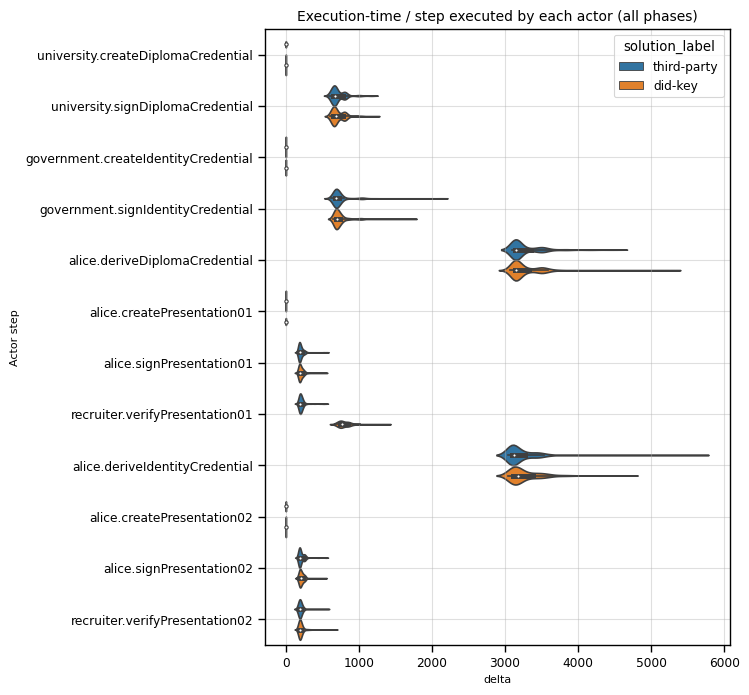

In [22]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (all phases)'
ax = sns.violinplot(df_tl.report,
                    **kwargs_violinplot,
                    order=df_stepname_order['actorStep'],
                    tight_layout=True,
                    ax=ax)
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(f'{kwargs_violinplot["x"]}')
ax.grid(alpha=.4)

plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-all-phases.png'),pad_inches=.5)
plt.show()

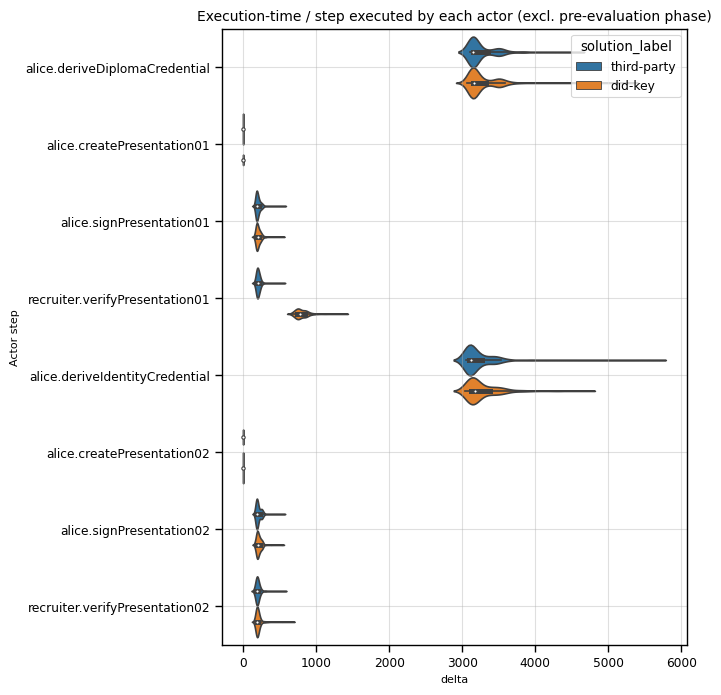

In [23]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (excl. pre-evaluation phase)'
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
order_data = df_stepname_order[df_stepname_order.phase != 'pre-evaluation']['actorStep']
ax = sns.violinplot(snsdata,
                    **kwargs_violinplot,
                    order=order_data,
                    tight_layout=True,
                    ax=ax,
                   )
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(VAR_X)
ax.grid(alpha=.4)
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-excl-pre-evaluation-phase.png'),pad_inches=.5)
plt.show()

In [24]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']

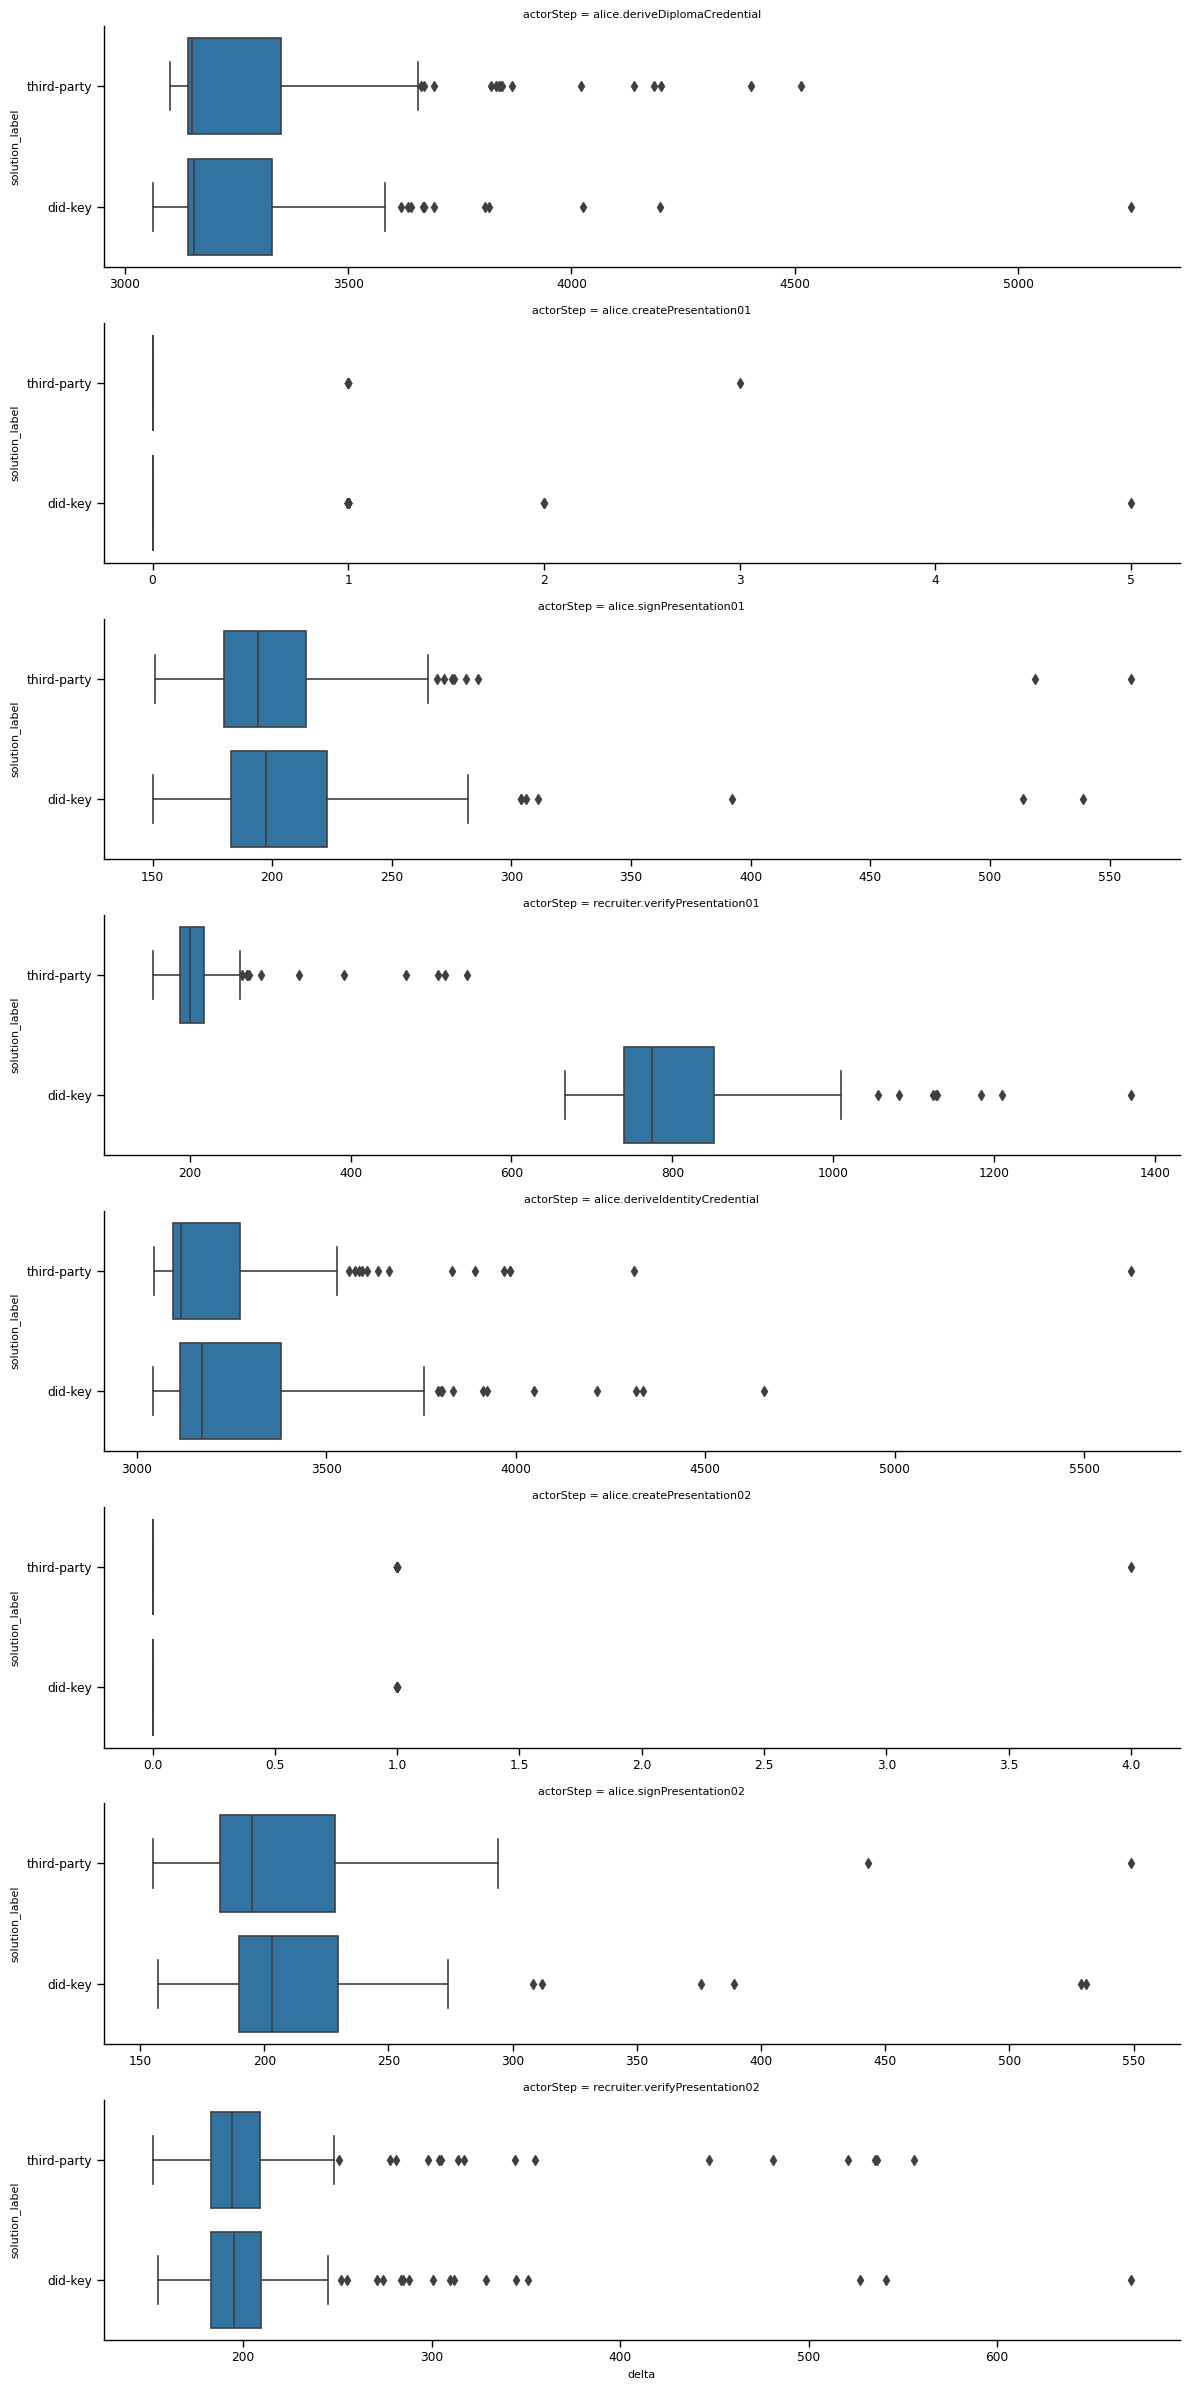

In [25]:
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.boxplot, x=VAR_X, y='solution_label')
plt.show()

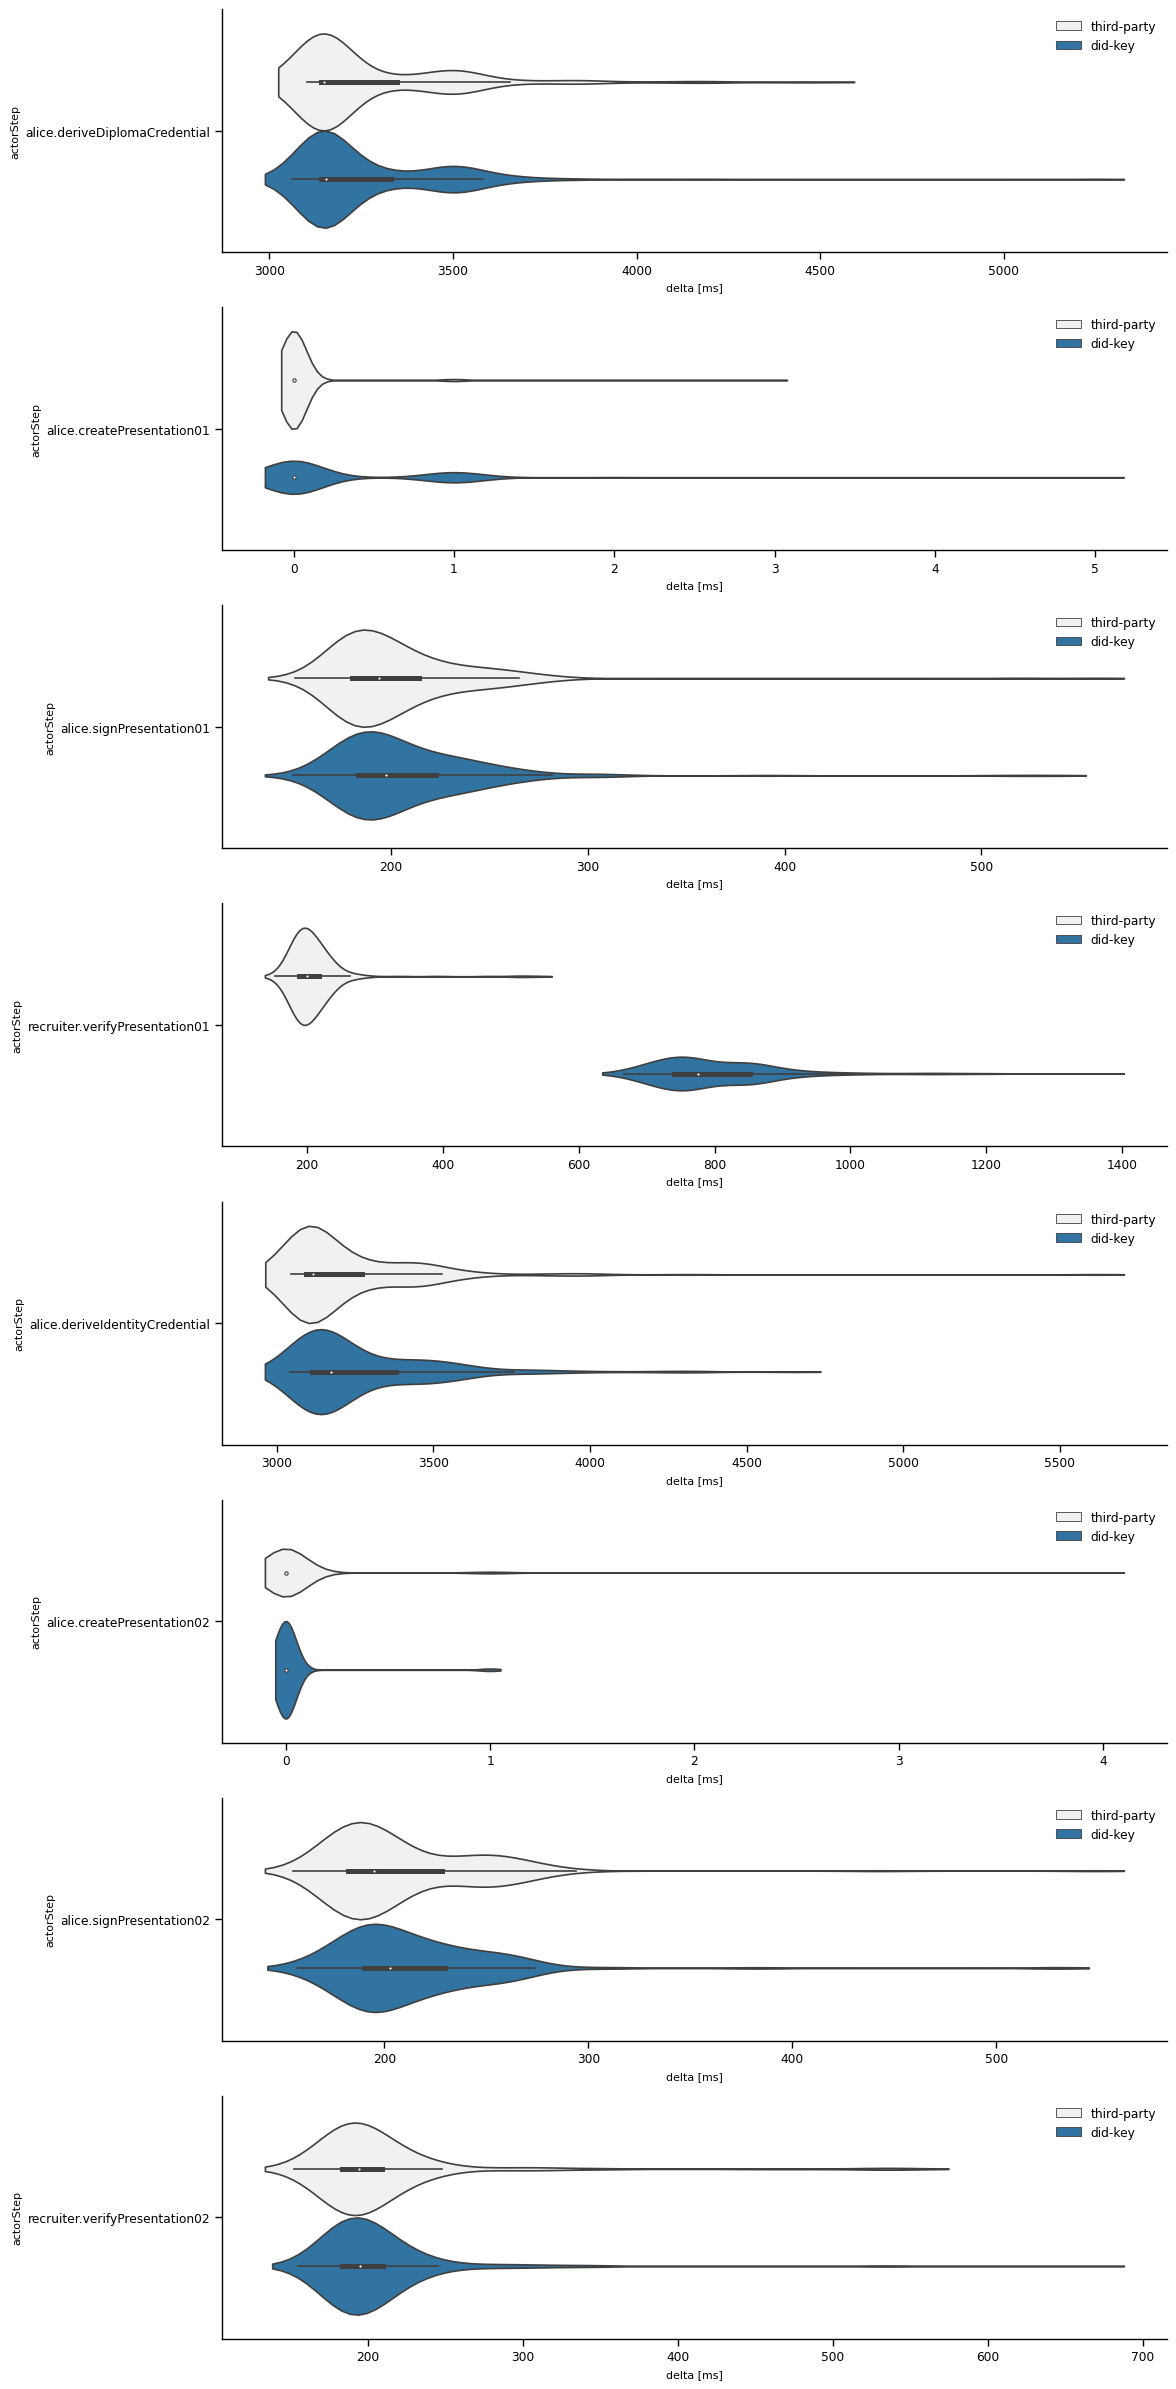

In [26]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='solution_label',
    orient='h',
    showfliers=False,
)

g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.violinplot,
                **kwargs_violinplot,
                #inner='point',
                #inner='quart',
#                split='quart',
                cut=1,
                inner_kws=dict(box_width=15, whis_width=2, color=".8")

                
               )
# Create main legend
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    ax.set_title('')
    # Add a copy of the main legend to each subplot
    ax.legend(handles=g.legend.legend_handles,frameon=False)

# Hide main legend
g.legend.set_visible(False)
g.tight_layout()
plt.show()

Compute & export aggregate statistics

In [27]:
# name refers to the function/step name
df_tl_agg = df_tl.report.groupby(['actorTag','solution_label','stepName'])[['delta']].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 8)

In [28]:
df_tl_agg.unstack('solution_label').swaplevel(1,2,axis=1).sort_index(axis=1)

delta                              \
solution_label                      did-key                               
                                      count        kurt   max      mean   
actorTag   stepName                                                       
alice      createPresentation01         250   22.637004     5     0.268   
           createPresentation02         250   37.460181     1     0.024   
           deriveDiplomaCredential      250   26.335629  5253  3265.664   
           deriveIdentityCredential     250    7.438434  4656  3269.864   
           signPresentation01           250   25.232765   539   207.972   
           signPresentation02           250   22.820186   531   214.464   
government createIdentityCredential     250   45.958347     1     0.020   
           signIdentityCredential       250   29.314323  1719   735.016   
recruiter  verifyPresentation01         250    6.626223  1370   803.136   
           verifyPresentation02         250   40.229946   671   205.788   
university createDiplomaCredential      250  122.467644     1     0.008   
           signDiplomaCredential        250    4.590408  1214   717.712   

                                                                          \
solution_label                                                             
                                     median   min       skew         std   
actorTag   stepName                                                        
alice      createPresentation01         0.0     0   3.451625    0.541617   
           createPresentation02         0.0     0   6.257839    0.153356   
           deriveDiplomaCredential   3154.0  3062   3.801480  221.669041   
           deriveIdentityCredential  3172.0  3042   2.320618  240.115696   
           signPresentation01         197.5   150   3.979683   42.587439   
           signPresentation02         203.0   157   3.730083   43.213218   
government createIdentityCredential     0.0     0   6.898604    0.140281   
           signIdentityCredential     700.0   650   4.286460  107.373498   
recruiter  verifyPresentation01       775.0   667   2.002402   97.402188   
           verifyPresentation02       195.0   155   5.547177   51.108113   
university createDiplomaCredential      0.0     0  11.112513    0.089263   
           signDiplomaCredential      680.0   599   1.863542  101.148530   

                                                                             \
solution_label                      third-party                               
                                          count        kurt   max      mean   
actorTag   stepName                                                           
alice      createPresentation01             250  107.675580     3     0.032   
           createPresentation02             250  113.418110     4     0.048   
           deriveDiplomaCredential          250    7.132112  4515  3270.816   
           deriveIdentityCredential         250   37.914977  5623  3223.060   
           signPresentation01               250   36.849869   559   202.980   
           signPresentation02               250   22.311667   549   207.988   
government createIdentityCredential         250   79.959646     1     0.012   
           signIdentityCredential           250   52.450723  2126   729.688   
recruiter  verifyPresentation01             250   27.885441   545   209.772   
           verifyPresentation02             250   20.895845   556   207.264   
university createDiplomaCredential          250  146.861584     4     0.036   
           signDiplomaCredential            250    5.252526  1189   712.760   

                                                                          
solution_label                                                            
                                     median   min       skew         std  
actorTag   stepName                                                       
alice      createPresentation01         0.0     0   9.5

Compact overview of the each group's mean & median aggregates for the `delta`-variable.
Including the absolute difference between the aggregate stats.

In [29]:
df_actor_step_agg = df_tl_agg.unstack('solution_label').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean|count').round(2)
df_actor_step_agg_diff_abs = df_actor_step_agg.stack(0).diff(axis=1).droplevel(1, axis=1).dropna(axis=1,how='all').abs().rename({'delta':'diff_abs'}, axis=1).unstack()
df_actor_step_agg = pd.concat([
    df_actor_step_agg.swaplevel(0,1,axis=1).droplevel(0,axis=1),
    df_actor_step_agg_diff_abs
],axis=1)
df_actor_step_agg

count                 mean              \
                                    did-key third-party  did-key third-party   
actorTag   stepName                                                            
alice      createPresentation01         250         250     0.27        0.03   
           createPresentation02         250         250     0.02        0.05   
           deriveDiplomaCredential      250         250  3265.66     3270.82   
           deriveIdentityCredential     250         250  3269.86     3223.06   
           signPresentation01           250         250   207.97      202.98   
           signPresentation02           250         250   214.46      207.99   
government createIdentityCredential     250         250     0.02        0.01   
           signIdentityCredential       250         250   735.02      729.69   
recruiter  verifyPresentation01         250         250   803.14      209.77   
           verifyPresentation02         250         250   205.79      207.26   
university createDiplomaCredential      250         250     0.01        0.04   
           signDiplomaCredential        250         250   717.71      712.76   

                                     median             diff_abs          \
                                    did-key third-party    count    mean   
actorTag   stepName                                                        
alice      createPresentation01         0.0         0.0      0.0    0.24   
           createPresentation02         0.0         0.0      0.0    0.03   
           deriveDiplomaCredential   3154.0      3150.5      0.0    5.16   
           deriveIdentityCredential  3172.0      3117.0      0.0   46.80   
           signPresentation01         197.5       194.0      0.0    4.99   
           signPresentation02         203.0       195.0      0.0    6.47   
government createIdentityCredential     0.0         0.0      0.0    0.01   
           signIdentityCredential     700.0       691.5      0.0    5.33   
recruiter  verifyPresentation01       775.0       200.0      0.0  593.37   
           verifyPresentation02       195.0       194.0      0.0    1.47   
university createDiplomaCredential      0.0         0.0      0.0    0.03   
           signDiplomaCredential      680.0       677.0      0.0    4.95   

                                            
                                    median  
actorTag   stepName                         
alice      createPresentation01        0.0  
           createPresentation02        0.0  
           deriveDiplomaCredential     3.5  
           deriveIdentityCredential   55.0  
           signPresentation01          3.5  
           signPresentation02          8.0  
government createIdentityCredential    0.0  
           signIdentityCredential      8.5  
recruiter  verifyPresentation01      575.0  
           verifyPresentation02        1.0  
university createDiplomaCredential     0.0  
           signDiplomaCredential       3.0

In [30]:
df_tl_agg.unstack('solution_label').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean').round(2)

mean              median            
                                       delta               delta            
solution_label                       did-key third-party did-key third-party
actorTag   stepName                                                         
alice      createPresentation01         0.27        0.03     0.0         0.0
           createPresentation02         0.02        0.05     0.0         0.0
           deriveDiplomaCredential   3265.66     3270.82  3154.0      3150.5
           deriveIdentityCredential  3269.86     3223.06  3172.0      3117.0
           signPresentation01         207.97      202.98   197.5       194.0
           signPresentation02         214.46      207.99   203.0       195.0
government createIdentityCredential     0.02        0.01     0.0         0.0
           signIdentityCredential     735.02      729.69   700.0       691.5
recruiter  verifyPresentation01       803.14      209.77   775.0       200.0
           verifyPresentation02       205.79      207.26   195.0       194.0
university createDiplomaCredential      0.01        0.04     0.0         0.0
           signDiplomaCredential      717.71      712.76   680.0       677.0

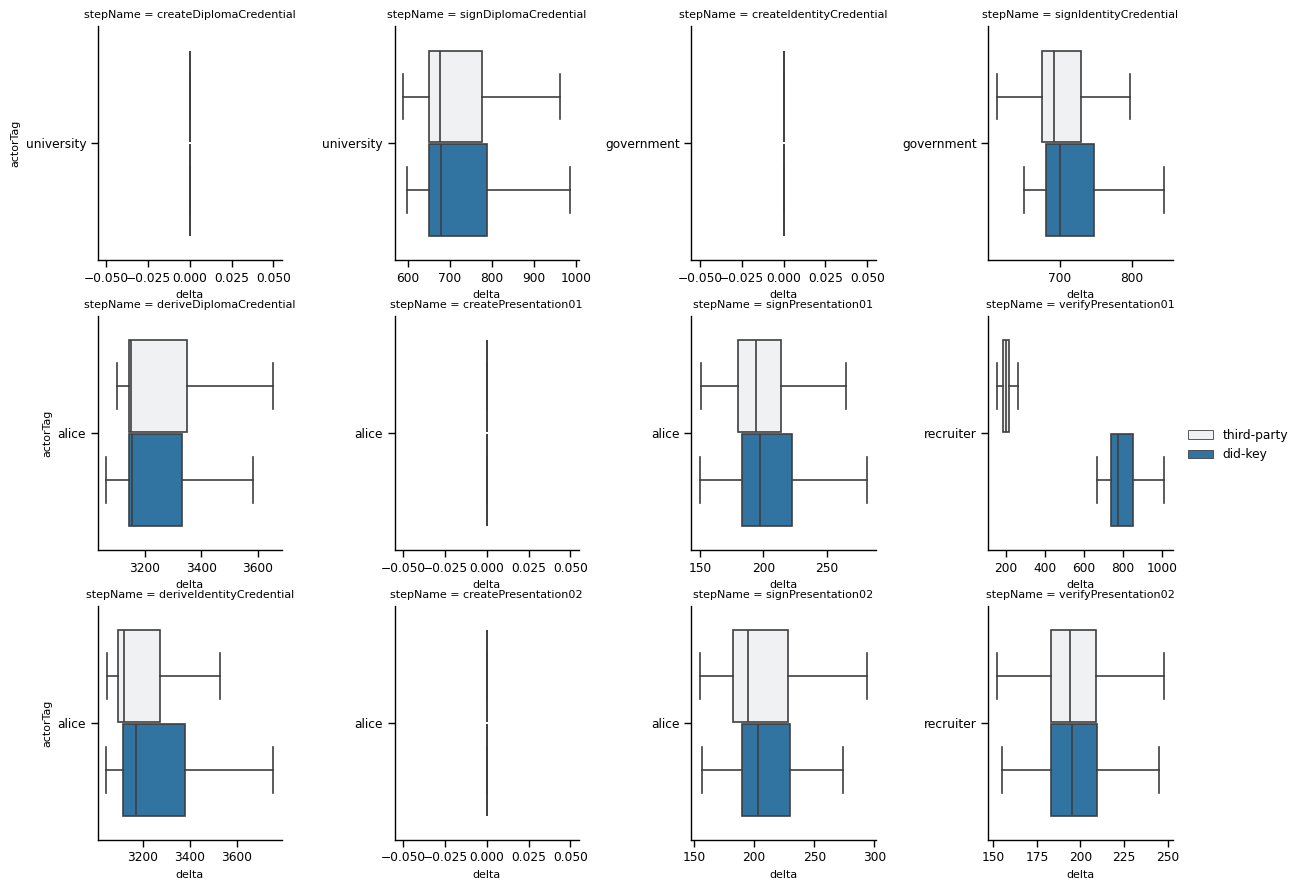

In [31]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='solution_label',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{}'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

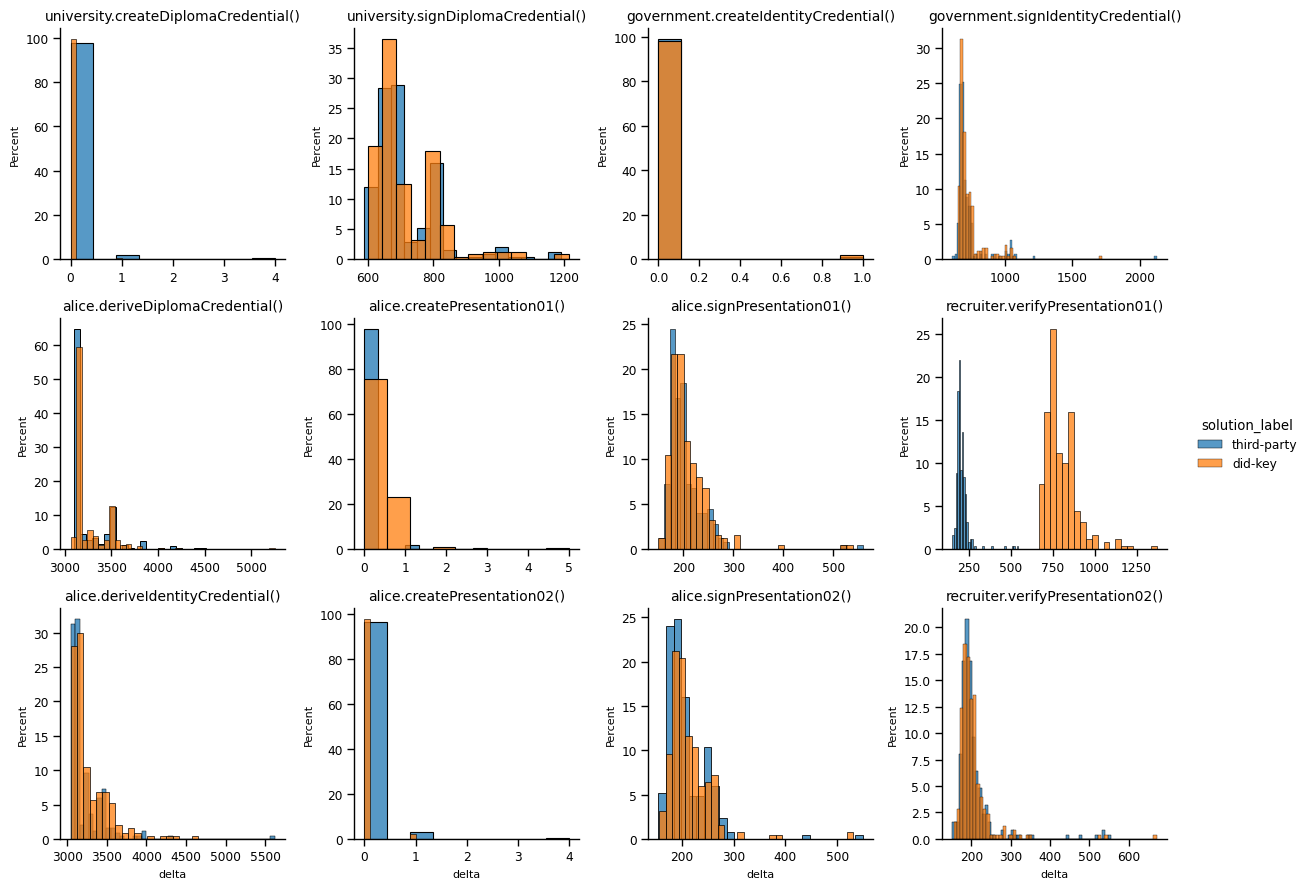

In [32]:
kwargs_fg = dict(col = 'stepName',
                 hue='solution_label',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x=VAR_X,
    stat='percent',
    element='bars',
    log_scale=False
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()


plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'),bbox_inches='tight')
plt.show()

In [37]:
df_tl.report.groupby(['phase','actorTag','solution_label','actorStep'])[['delta']].agg(['mean','count']).unstack('solution_label')

delta  \
                                                                      mean   
solution_label                                                     did-key   
phase          actorTag   actorStep                                          
phase-1        alice      alice.createPresentation01              0.278333   
                          alice.deriveDiplomaCredential        2843.568333   
                          alice.signPresentation01              179.031667   
               recruiter  recruiter.verifyPresentation01        765.116667   
phase-2        alice      alice.createPresentation02              0.046667   
                          alice.deriveIdentityCredential       2835.160000   
                          alice.signPresentation02              180.353333   
               recruiter  recruiter.verifyPresentation02        266.194444   
pre-evaluation government government.createIdentityCredential     0.036111   
                          government.signIdentityCredential     628.158333   
               university university.createDiplomaCredential      0.013889   
                          university.signDiplomaCredential      627.933333   

                                                                            \
                                                                             
solution_label                                                 third-party   
phase          actorTag   actorStep                                          
phase-1        alice      alice.createPresentation01              0.016667   
                          alice.deriveDiplomaCredential        2916.726667   
                          alice.signPresentation01              181.211667   
               recruiter  recruiter.verifyPresentation01        269.112637   
phase-2        alice      alice.createPresentation02              0.023333   
                          alice.deriveIdentityCredential       2923.966667   
                          alice.signPresentation02              183.186667   
               recruiter  recruiter.verifyPresentation02        275.793956   
pre-evaluation government government.createIdentityCredential     0.024725   
                          government.signIdentityCredential     648.994505   
               university university.createDiplomaCredential      0.024725   
                          university.signDiplomaCredential      646.115385   

                                                                       \
                                                                count   
solution_label                                                did-key   
phase          actorTag   actorStep                                     
phase-1        alice      alice.createPresentation01              600   
                          alice.deriveDiplomaCredential           600   
                          alice.signPresentation01                600   
               recruiter  recruiter.verifyPresentation01          360   
phase-2        alice      alice.createPresentation02              600   
                          alice.deriveIdentityCredential          600   
                          alice.signPresentation02                600   
               recruiter  recruiter.verifyPresentation02          360   
pre-evaluation government government.createIdentityCredential     360   
                          government.signIdentityCredential       360   
               university university.createDiplomaCredential      360   
                          university.signDiplomaCredential        360   

                                                                           
                                                                           
solution_label                                                third-party  
phase          actorTag   actorStep                                        
phase-1        alice      alice.createPresentation01                  600  
                      

In [33]:
# TODO: REFACTOR
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

## Statistics

In [34]:
raise Exception('BELOW NEEDS REVISION. BREAKING CHANGES SINCE PROFILER-V2')

Exception: BELOW NEEDS REVISION. BREAKING CHANGES SINCE PROFILER-V2

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [315]:
p_thresh = .05

In [316]:
steps = df_tl.report.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [324]:
steps= [

 'deriveDiplomaCredential',
    'createPresentation01', 'signPresentation01',
 'verifyPresentation01', 'deriveIdentityCredential', 'createPresentation02'
 'signPresentation02', 'verifyPresentation02'
]

> Breaking since profiler-v2 update

In [325]:
grpr_className = df_tl.report.groupby('solution_label')
assert grpr_className.ngroups == 2 # sanity check
A,B = grpr_className

In [326]:
df_a

,actorStep,actorTag,className,delta,end,start,stepName,solution_label,phase,delta_log1p
300,university.createDiplomaCredential,university,SolidVCActor,0,1701853957896,1701853957896,createDiplomaCredential,did-key,pre-evaluation,0.000000
302,university.createDiplomaCredential,university,SolidVCActor,0,1701854914817,1701854914817,createDiplomaCredential,did-key,pre-evaluation,0.000000
304,university.createDiplomaCredential,university,SolidVCActor,0,1701853325034,1701853325034,createDiplomaCredential,did-key,pre-evaluation,0.000000
305,university.createDiplomaCredential,university,SolidVCActor,0,1701854361009,1701854361009,createDiplomaCredential,did-key,pre-evaluation,0.000000
306,university.createDiplomaCredential,university,SolidVCActor,0,1701854009410,1701854009410,createDiplomaCredential,did-key,pre-evaluation,0.000000
...,...,...,...,...,...,...,...,...,...,...
9493,recruiter.verifyPresentation02,recruiter,SolidVCActor,284,1701822304310,1701822304026,verifyPresentation02,did-key,phase-2,5.652489
9494,recruiter.verifyPresentation02,recruiter,SolidVCActor,219,1701822583887,1701822583668,verifyPresentation02,did-key,phase-2,5.393628
9495,recruiter.verifyPresentation02,recruiter,SolidVCActor,237,1701822559216,1701822558979,verifyPresentation02,did-key,phase-2,5.472271
9496,recruiter.verifyPresentation02,recruiter,SolidVCActor,250,1701822000619,1701822000369,verifyPresentation02,did-key,phase-2,5.525453


In [327]:
steps

['deriveDiplomaCredential',
 'createPresentation01',
 'signPresentation01',
 'verifyPresentation01',
 'deriveIdentityCredential',
 'createPresentation02signPresentation02',
 'verifyPresentation02']

In [328]:
_var = VAR_X
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        if np.shape(a) != np.shape(b):
            print(f'Groups for step: {step_name} are different:', np.shape(a), np.shape(b))
        assert np.shape(a) == np.shape(b)

        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference (p<{p_thresh}) in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results.to_csv(os.path.join(DIR_REPORT, 'df_significance-tests.csv'))
df_test_results


    Group A: did-key
    Group B: third-party
    Tested variable: delta

Groups for step: verifyPresentation01 are different: (254,) (248,)


AssertionError: 

In [37]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(list(steps_with_sig_diff))

['createDiplomaCredential', 'createIdentityCredential', 'deriveDiplomaCredential', 'createPresentation01', 'verifyPresentation01', 'deriveIdentityCredential', 'createPresentation02', 'verifyPresentation02']


In [38]:
df_tl_sig_diff = df_tl.report[df_tl.report.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(25776, 9)

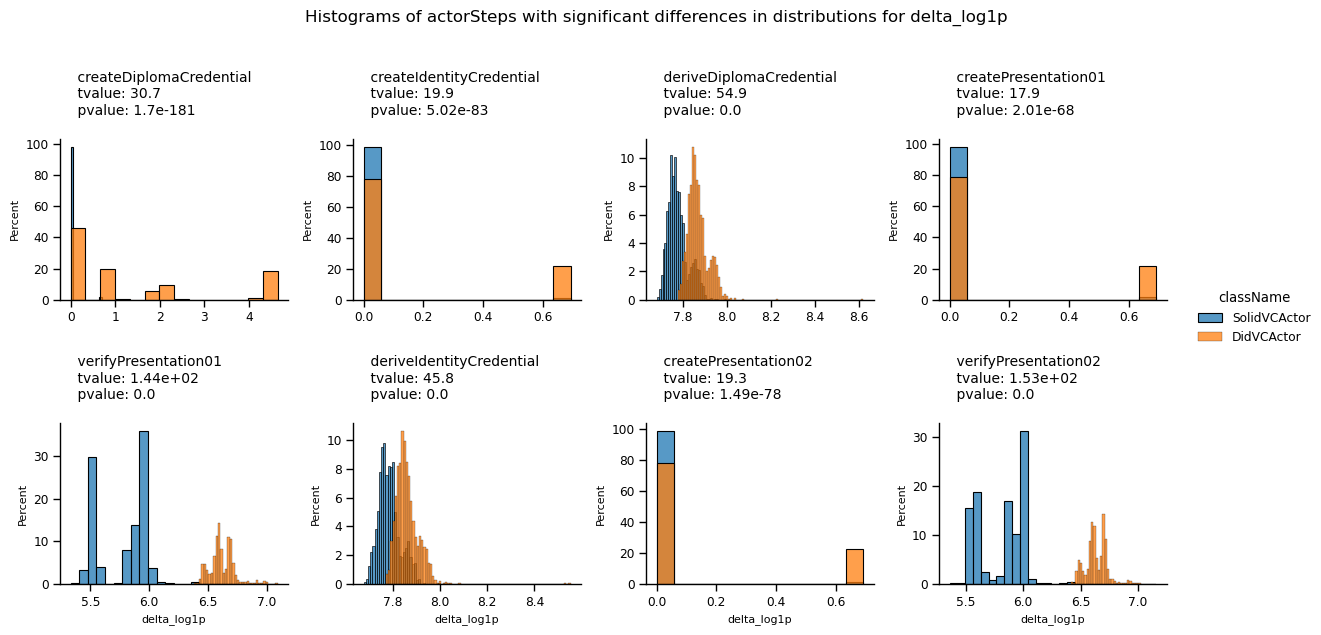

In [39]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False, col_wrap=4)
g = g.map_dataframe(sns.histplot,
                    x=VAR_X,
                    stat='percent',
                    element='bars')
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')
    
g.tight_layout()
suptitle = plt.suptitle(f'Histograms of actorSteps with significant differences in distributions for {VAR_X}',y=1.05)
plt.show()

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [40]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [41]:
_var = 'delta_log1p'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        

colname_effect_size =f'cohend_{k_a}_{k_b}__{_var}'
s_effect_sizes = pd.Series(effect_size_per_step, name=colname_effect_size)

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
def create_explanation(r) -> str:
    es = r[colname_effect_size]
    pos = es > 0
    ec = r.effect_class
    
    return f'The mean of {k_a} is {"greater" if pos else "smaller"} than the mean of {k_b}, with effect size: {es} (which can be classified as {ec}).'
df_effect_sizes['explanation'] = df_effect_sizes.apply(create_explanation, axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))
df_effect_sizes

,cohend_DidVCActor_SolidVCActor__delta_log1p,effect_class,explanation
createDiplomaCredential,1.080773,LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.0807728471248015 (which can be classified as LARGE)."
signDiplomaCredential,-0.023923,VERY_SMALL,"The mean of DidVCActor is smaller than the mean of SolidVCActor, with effect size: -0.023923086355168335 (which can be classified as VERY_SMALL)."
createIdentityCredential,0.700366,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.7003657426658256 (which can be classified as MEDIUM)."
signIdentityCredential,0.015874,VERY_SMALL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.01587384994798249 (which can be classified as VERY_SMALL)."
deriveDiplomaCredential,1.935375,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.9353750560549572 (which can be classified as VERY_LARGE)."
createPresentation01,0.630884,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6308841479017578 (which can be classified as MEDIUM)."
signPresentation01,0.006504,NIHIL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.006504101508290548 (which can be classified as NIHIL)."
verifyPresentation01,5.065694,HUGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 5.065694180002759 (which can be classified as HUGE)."
deriveIdentityCredential,1.612722,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.6127219828890706 (which can be classified as VERY_LARGE)."
createPresentation02,0.679689,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6796890528600683 (which can be classified as MEDIUM)."


/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_5415/1671008354.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)


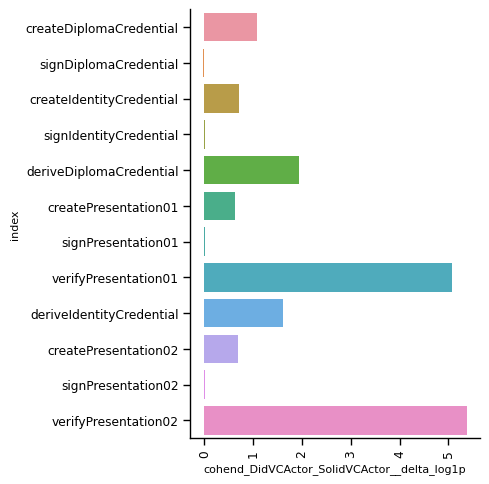

In [42]:
g= sns.catplot(df_effect_sizes.reset_index(),y='index',x=colname_effect_size, kind='bar',orient='h')
g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)
plt.show()

---
### [WIP] Analyze effects of document loader cache option configurations

In [68]:
def plot_stepname_histograms_per_dlco_group(df: pd.DataFrame, selected_stepName: str):
    # Create grouper based on different document loader cache configurations
    GROUP_COLUMNS_DLCO = df[['dlco']].columns.to_list()
    grpr_dlco = df.groupby(GROUP_COLUMNS_DLCO)
    snsdata = pd.concat({ f'G{i}': grpr_dlco.get_group(k) for i,k in enumerate(grpr_dlco.groups.keys()) }).report.reset_index().rename({'level_0':'dlco_group'}, axis=1)
    snsdata = snsdata[snsdata.stepName == selected_stepName]
    df_dlco_group_table = pd.concat({ f'G{i}': grpr_dlco.get_group(k) for i,k in enumerate(grpr_dlco.groups.keys()) }).reset_index().rename({'level_0':'dlco_group'}, axis=1)[['dlco_group','dlco']].drop_duplicates().droplevel(0, axis=1).dropna(how='all',axis=1).rename({'':'DLCO_GROUP'},axis=1).set_index('DLCO_GROUP').T
    df_dlco_group_table_marks = df_dlco_group_table.replace({True: '√', False: 'x'})

    g = sns.FacetGrid(snsdata,row = 'dlco_group',aspect=4,sharex=True, sharey=True, hue='className')
    g.map_dataframe(sns.histplot,x='delta_log1p', stat='percent')
    g.add_legend()

    for g_k, ax_k in g.axes_dict.items():
        g_size = snsdata.groupby('dlco_group').size()[g_k]
        title_center = ax_k.get_title()
        ax_k.set_title(f'{g_k}\n',loc='left')
        ax_k.set_title("\n".join(map(lambda x: '{}: {}'.format(*x), df_dlco_group_table_marks[g_k].to_dict().items())),loc='center', )
        title_right = f'{selected_stepName}\nN: {g_size}'
        ax_k.set_title(title_right,loc='right', fontdict = {'fontsize': 8})

    g.tight_layout()
    
    return g

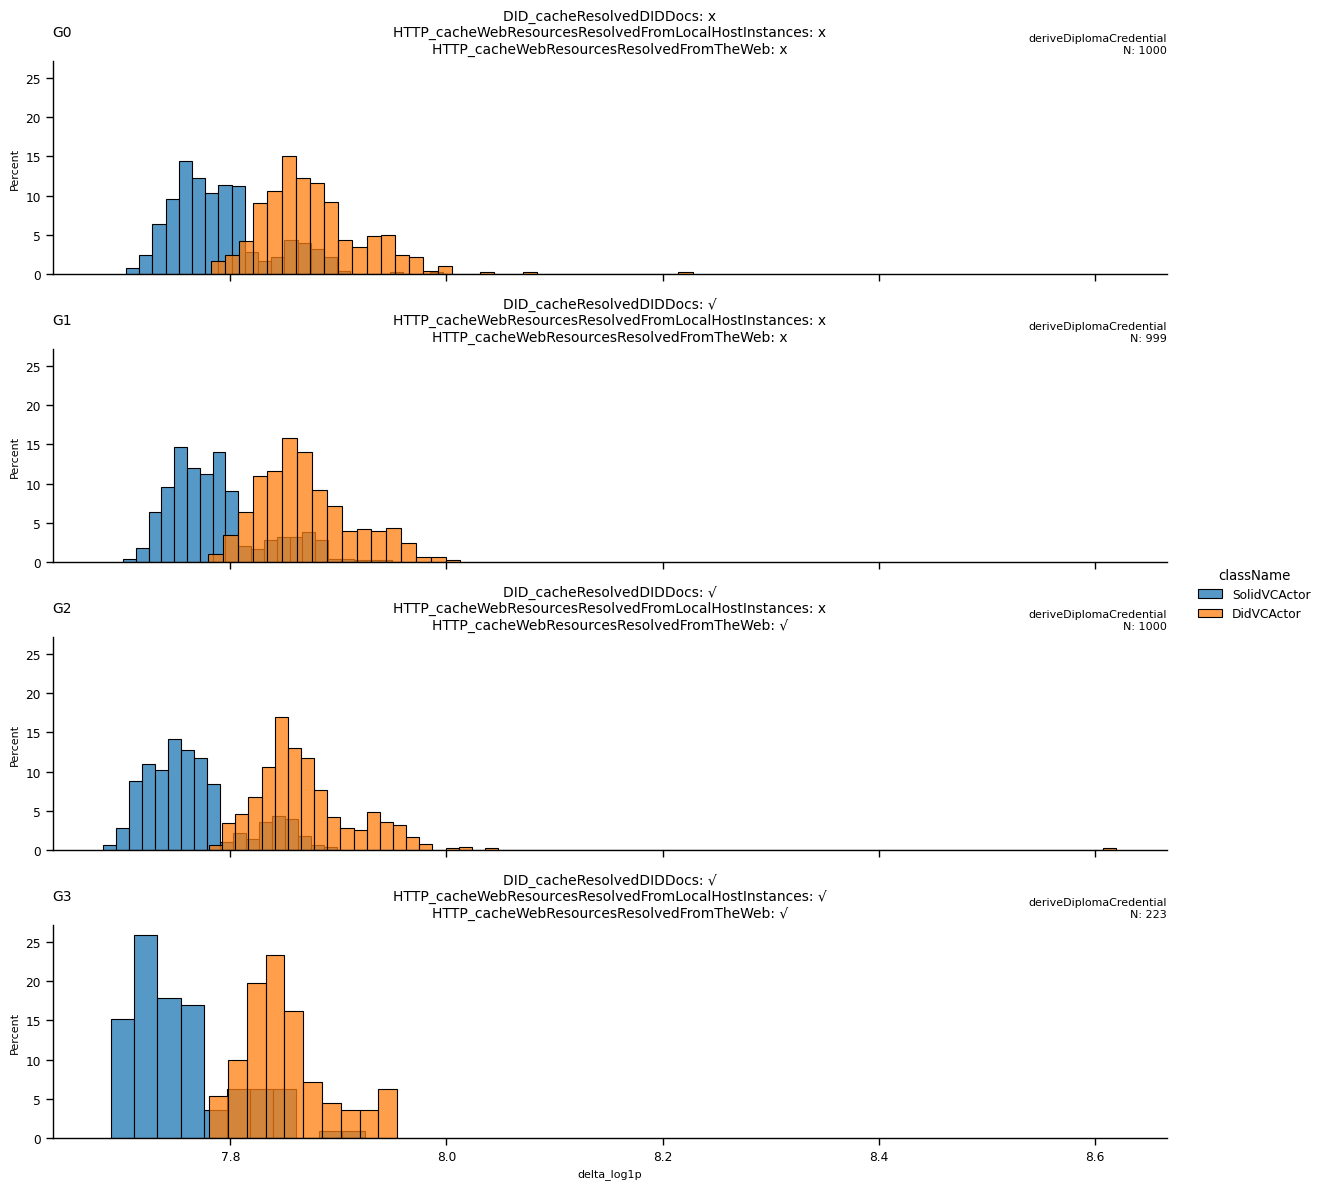

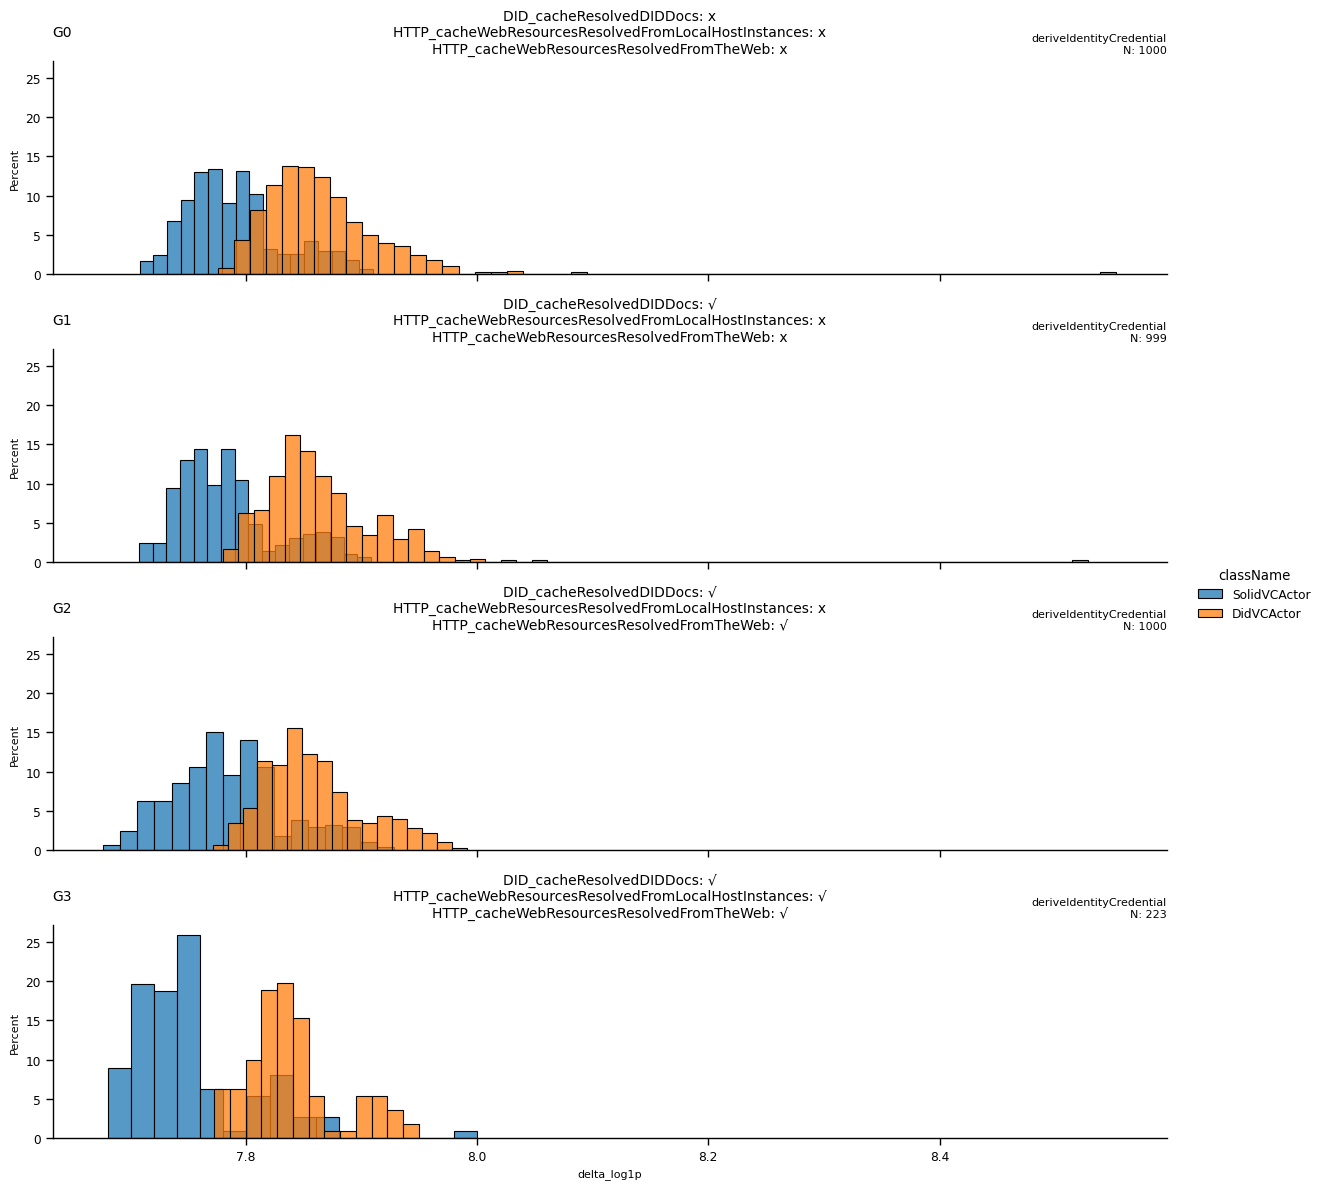

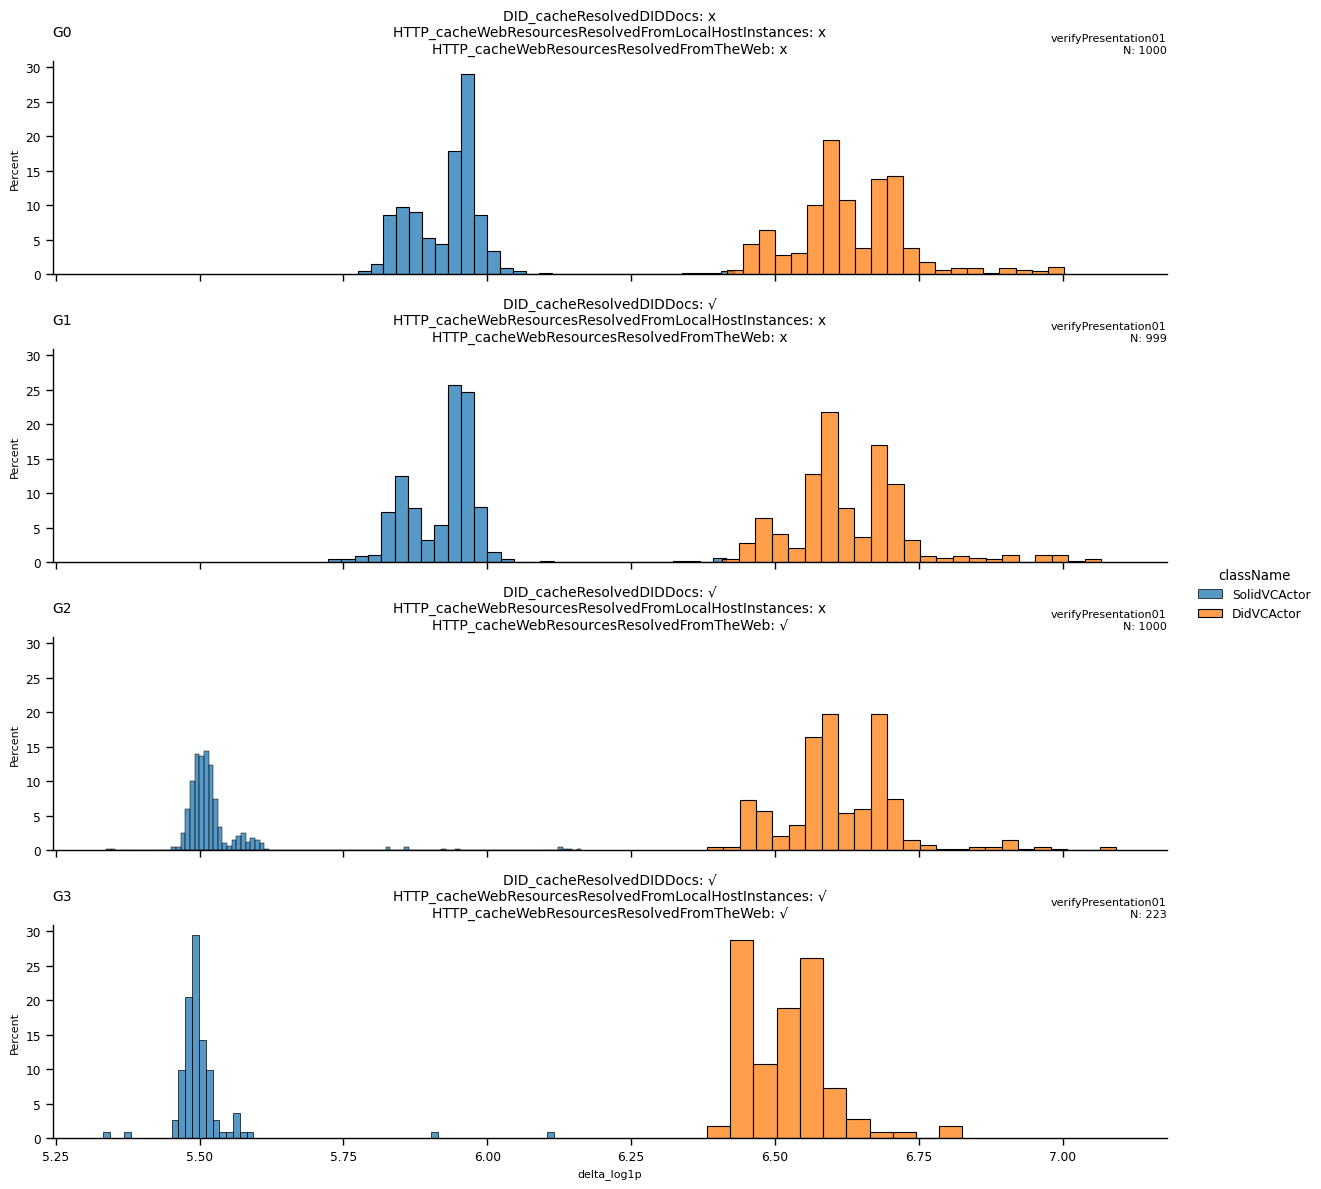

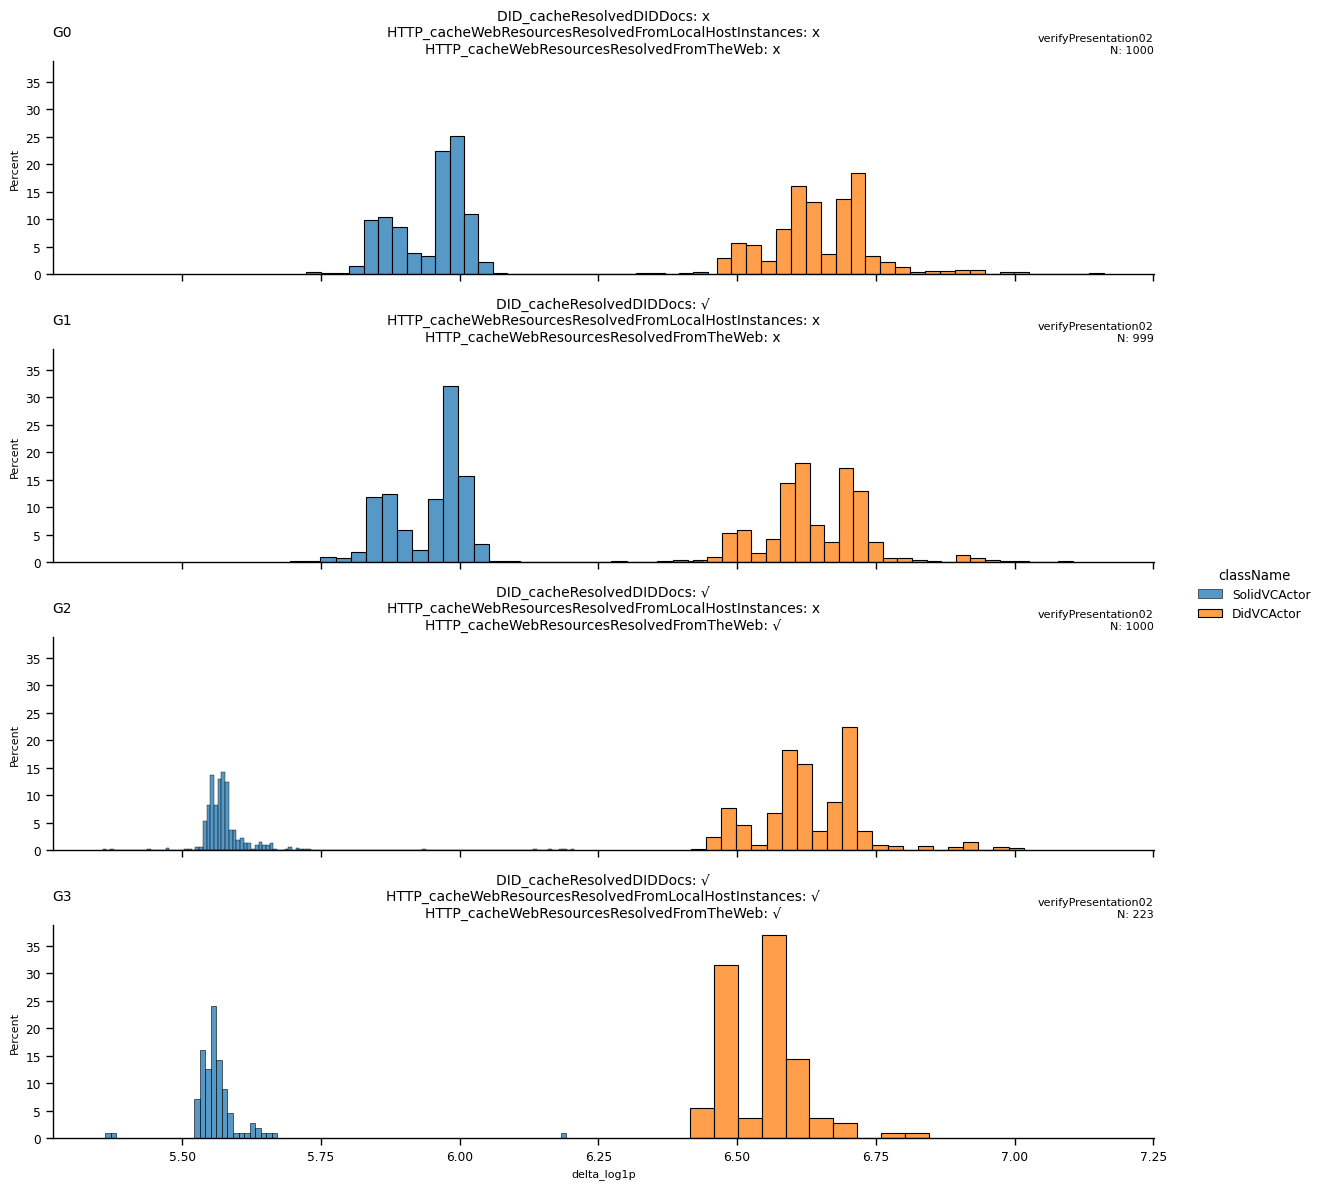

In [74]:
for sn in [ 'deriveDiplomaCredential', 'deriveIdentityCredential', 'verifyPresentation01', 'verifyPresentation02']:    
    g = plot_stepname_histograms_per_dlco_group(df_tl, sn)
    g.savefig(os.path.join(DIR_REPORT, f'histograms-per-dlco-group_{sn}.png'))